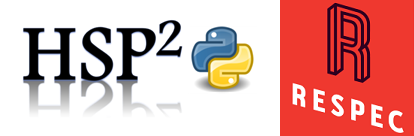

# Understanding HSP2

## INTRODUCTION

HSPsquared (or HSP2) is an implementation of HSPF in Python. The plan is to evolve HSP2 to include all major HSPF functionality. This document will help the user understand the design of HSP2.

HSPF was written under the constraints of 1980's FORTRAN running on computers with very limited memory by modern standards. Early FORTRAN only supported fixed size arrays which set hard coded limits on HSPF such as the number of PERLND, IMPLND, and RCHRES segments. The limited memory was handled in HSPF by the use of FORTRAN common blocks which required the HSPF code to interweave data access with functional code.

The philosophy of HSP2 is to remove all HSPF hard coded restrictions and to separate the control logic from the engineering codes. The control logic controls the movement of data, the aggregation and disaggregation of time series, reading and storing data, units conversion, date and time algorithms, etc. The engineering code consists of the essential algorithms to compute hydrology, chemical and biochemical reactions, transport of materials, heat transport, etc.  In HSP2, the data needed in the engineering code for an specific operation, activity, and segment (like PERLND PWATER P001) is prepared before its activity function is called by the control code.  After the activity function call returns with any resulting error messages and associated error counts, the control logic stores the computed time series specified by the user to the HDF5 file. This makes a clear separation between the control code and the engineering code.

This discussion is divided into sections for the HSP2 computer language, data storage, engineering code, and control code.

## THE COMPUTER LANGUAGE

HSPF was written in FORTRAN which was at the time the only computer language available for science and engineering.  Although FORTRAN has advanced over time to remain a modern computer language,  FORTRAN is not often taught to engineers and scientists in colleges.  Its new features have made it more complex to learn than the original FORTRAN.  FORTRAN still generates executable code that runs faster than that of other modern languages, but the performance gap is not usually significant.

HSP2 is written in Python.  Python is a modern computer language that is easier to learn than most other languages, is widely taught, and is commonly used in science and engineering.  One of Python's strengths is the very large number of third party libraries supporting science and engineering.  Experience with development of other science and engineering codes in many languages drove the selection of Python for HSP2.

Early versions of HSP2 were written in Python 2.4+.  Now, HSP2 has been redesigned requiring Python 3.7+. HSP2 requires a few additional third party libraries (Numpy, Numba, and Pandas.) Numpy brings matrix, vector and general array functions to Python which are actually implemented in FORTRAN and C++ for good performance.   Python with Numpy is often called "the poor man's MATLAB".  Numba is a Just-In-Time (JIT) compiler for a subset of Python and Numpy.  It creates fast machine language code which is cached for later reuse. So the first time HSP2 is run on your computer, the run time is slowed by the compilation. The compilation is not performed again unless it detects a code modification date later than the last compilation date.  Pandas is a hugely popular library for data clean up and time series aggregation and disaggregation.  (These are sometimes referred to as "data munging".)  Pandas in HSP2 is used for time series operations like aggregation and disaggregation, fetching and storing data, date and time conversion, etc.  The JIT compiler (LLVM) is automatically installed and configured with Numba and is invisible to HSP2 users.

Using Numba, the engineering code is executed at nearly C computer language speeds. Since the control logic is still ordinary Python and cannot at this time be accelerated by Numba, the run time speed is in between pure Python speed and pure machine language speed.  HPS2 can be run with Numba disabled (by setting a system Numba environmental variable or commenting out the Numba "decorations" in the HSP2 code) at an large increase in run time - so this is not available as a HSP2 user option.  However, HSP2 testing does include running without Numba to ensure the accuracy of HSP2 in case of a Numba bug or issue.

Numba caches its code in a _pycache_ directory for later reuse.  On Windows there is  a  _pycache_ directory inside the HSP2 code directory by default, but this location can be changed by a system administrator.  Python also caches its preprocessed code in the same cache directory.  Users do not need to be concerned about the cache except to not delete it if they come across it.  (HSP2 will still run, but Numba will need to recompile HSP2 and restore the directory which will take extra time during the next run.) HSP2 developers should configure Git to ignore the cache directory for private forks of the HSP2 GitHub repository.

Python, Numpy, Pandas, and Numba are available for free.  However, obtaining these libraries from their different sources and insuring compatible versions is a bit painful.  Users are encouraged to use a free scientific/engineering Python distribution like Anaconda's Individual Edition to install and update these codes for use with HSP2.

## DATA STORAGE

HSPF uses a variety of different data storage mechanisms. A few examples include UCI files which are text, WDM and HBN files which are different binary, direct-access files, and TSS (obsolete).

In contrast, HSP2 uses one data storage mechanism, HDF5 (Hierarchical Data Format, version 5), to store all data. Essentially, anything required to document, run, or save simulation results lives in the HDF5 file.  The only thing outside the HDF5 file in HSP2 is the code itself - but HSP2 does save the version numbers of all Python libraries and HSP2's version number to the HDF5 file after each run.

HDF5 is a widely used for scientific and engineering data. HDF5 scales from laptop computers to supercomputers. The HDF5 file can store small to extremely large amounts of data that require the HDF5 file to be spread across a disk farm. HDF5 is very fast, cross platform, trivially transportable between platforms, and stores arbitrary metadata with data.  The HDF Group (a 501c3 nonprofit company) provides the HDF5 library for different computer platforms, fixes bugs in the HDF5 code, and advances the capabilities of HDF5.  It is free and automatically installed with Pandas (which actually uses Pytables internally to interface with the HDF5 library).  Python has another library, H5py, which works with the HDF5 library for advanced features. H5py may also be used by HSP2 in the future.

HDF5 is actually very efficient in terms of storage size, but users might notice a new HDF5 file seems too large. The initial B-Trees, free and used storage block lists, the user defined user block, etc. are allocated at the creation (and will grow as needed) making the initial size seem large. But as data is added, the file size approaches the HDF5 design goal of one and a tiny fraction byte for each byte of actual data. HDF5 also supports optional data compression algorithms.  HSP2 currently uses BLOSCLZ lossless compression to store computed results (for faster run time performance rather than making a smaller file which is a bonus.) Although all HSP2 calculations are done with double precision accuracy, HSP2 stores calculated data in single precision (at all the calculated time intervals) in the HDF5 file. Single precision storage further reduces the HDF5 file size. HSP2 stores metadata as HDF5 datasets rather than using the HDF5 metadata storage since this is easier for the user and provides better performance. (Storing metadada in summary tables is the hidden assumption of Pandas in that it does not expose high level routines for users to access metadata.)  

Modern releases of the HDF5 library can reuse data blocks released during a session - but only during that same session (from opening the HDF5 file to closing it.)  So rerunning simulations does not cause significant change in the size of the HDF5 file since the new results are typically the same size as the old results. Value changes in UCI like tables do not change their size. The fast growth of the HDF5 file during additional runs in the was a problem for early versions of HSP2 which used an earlier version of HDF5.

HDF5 files can link internally to other HDF5 files for transparent sharing of data. HSP2 does not use this capability since this is an advanced feature of HDF5 and is not supported by Pandas.  However, HSP2 in its EXT_SOURCES table, allows the user to specify individually for each time series that the time series is located in the local HDF5 file or located in another named HDF5 file. This would allow users to establish a single source of (say) meteorological data to be stored in one central HDF5 file which is used by all analysts or researchers without duplicating it into their own HDF5 simulation files to ensure better data consistency and traceability.  There is very little preformance penalty if the HDF5 files are connected with a high speed network.

HSP2 uses Pandas to read and write to the HDF5 file.  Although HDF5 allows users to create arbitrarily complex datasets,  HSP2 uses only Pandas Series and Pandas DataFrames as HDF5 datasets.  A Pandas Series is a one dimensional array which frequently uses Pandas Timestamps (like UNIX epoch time) as an index array associated with the data.  A Pandas DataFrame is a two dimensional array which typically uses either  Pandas Timestamps for the index (for a table of computed time series) or segment IDs for an index (for tables of HSPF UCI like data.)  The DataFrame columns may be different data types (such as strings, integers, and floats) but all data in a column must have the same data type and all columns must be the same length to be stored in an HDF5 file by Pandas.

The HDF Group provides a number of free command line utilities to work with HDF5 files. These are not needed by HSP2, but users might find them useful. 

### INTERNAL STRUCTURE OF THE HSP2 HDF5 FILE

HDF5 internally uses B-trees, dataset chunking, optional data compression algorithms, free block lists, metadata storage, etc. that only very advanced HDF5 users need to understand.  HSP2 users can totally ignore this internal complexity.  

So conceptually, HDF5 files internally look to the user like a UNIX filesystem. That is, from the root '/', there may be any number of directories (called groups in HDF5) and files (called datasets in HDF5).  Directories may contain any number of other directories and files to any level.  There are no size restrictions for groups and datasets.  

Free tools such as HDFView (downloadable from the HDF Group) can be used to see the internal structure, metadata and content of any HDF file ever created on any computer platform on your computer. HDF5 is the closest thing to true archival storage for scientific and engineering data. 

The following graphic is a snapshot from HDFView for the HSP2 test10 HDF5 file. It shows the HSP2 data organization in a tree like view. The tree starts with the UNIX / but it is not explicitly shown.   Only the most important information is shown to keep this readable. So most subdirectories have not been expanded.  Indentation indicates a subdirectory.

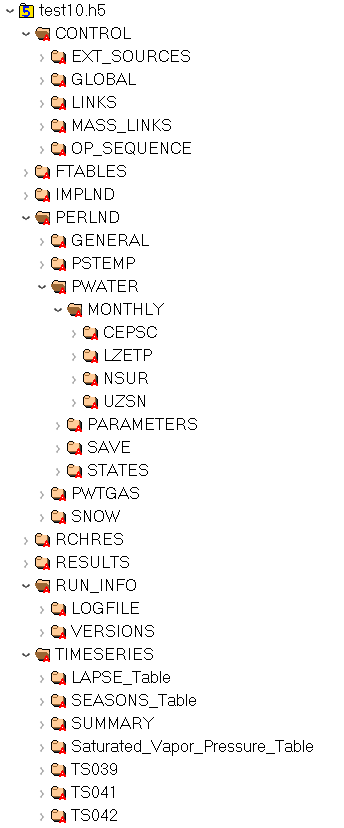

Actually, much more information is stored in test10.h5 file than shown above - but it is important to make the overall data organization understandable and yet fit in a small graphic.  

The tree structure in the graphic translates directly to the HDF5 path names. For example,
``` /PERLND/PWATER/MONTHLY/CEPSC``` 
specifies the DataFrame containing the CEPSC information for the PERLND operation and PWATER activity. Essentially, it is a table with the rows labeled with names of the PERLND segments and the column names JAN,...,DEC.
This is shown in the cropped HDFView below

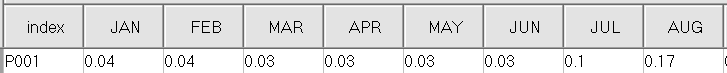

A time Series example is 
``` /TIMESERIES/TS039``` which is the path to a time Series extracted from the orignal WDM file with ID 39.

Another example (not expanded in the graphic above) is
``` /RCHRES/HYDR/PARAMETERS``` which is a DataFrame containing the RCHRES HYDR PARAMETERS information. This is shown in the HDFView snapshot below (which was cropped to fit).

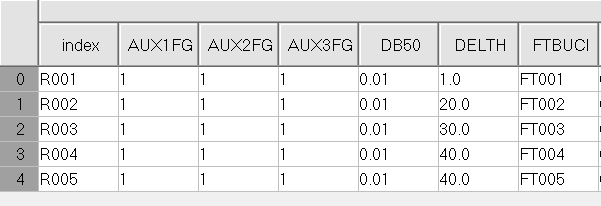

An example (also not shown in the directory tree above) of an HSPF FTABLE in HSP2 is 
```/FTABLES/FT001``` which is shown in the HDFView snapshot below.

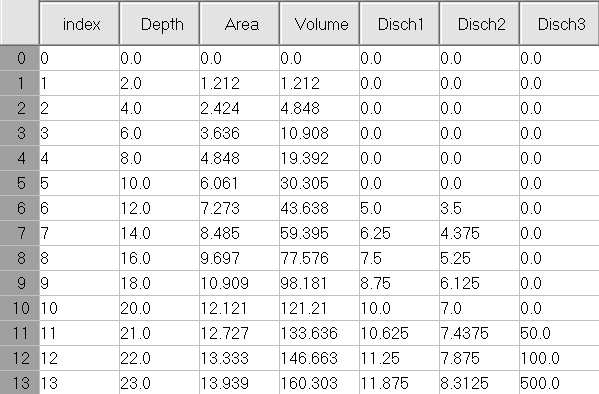

In order to restore the original Pandas object (Series or DataFrame) when reading from the HDF5 file,  each Pandas dataset has an associated directory (\_i\_table) with subdirectories in the HDF5 file to provide Pandas column and index information for the data. These are invisible to HSP2 users accessing the data via Pandas, but can be seen with HDFView.  The tiny red mark in the bottom right corner of the directory icons in the directory tree (above) indicates this additional information which can be expanded for viewing.

Most of the HSP2 dataset names will be familiar to HSPF users. The HSP2 datasets store the same information as expected in HSPF. 

The TIMESERIES directory stores a summary table,
```/TIMESERIES/SUMMARY,```  with metadata extracted from the WDM files.
This metadata includes start and stop datetimes, frequency, fill value, location, constituent, etc.

The TIMESERIES directory also stores the HSP2 LAPSE table (English units), SEASONS table, and Saturated Vapor Pressure table. These tables remove the data from being embedded into the HSP2 code as they are in HSPF.  It makes their maintenance simpler and user controlled if necessary.  

By now, readers will have noticed a difference between HSPF and HSP2. In HSP2, all names of time Series, FTABLES, segment names for PERLND, IMPLND, and RCHRES, etc.  are arbitrary strings. For example, a PERLND segment could be named '1', 'P001', 'ASPEN FOREST', or 'P100.012.099'. The convention of starting names with P (PERLND), I (IMPLND), R (RCHRES), TS (time Series), FT (FTABLE) is used for all examples HDF5 files included with HSP2.

HSP2 users can add any number of additional columns to any DataFrame. For example, comments and land use columns are frequently useful. The only restriction is that the name must not already be in use in that DataFrame.  These column names can be arbitrary strings - but Pandas will generate warning messages for strings that don't follow the Unix filename convention. That is, the string must start with a letter and be followed by letters, numbers, and the underscore character. Upper and lower case letters are distinct. This is also the standard variable naming convention in most computer languages.  Everything will work with this specific warning message, but you might not notice other serious warnings if too many of these warnings are present. Handling arbitrary unicode characters is really only partially supported in HDF5.

Users can store any other desired information in directories that don't interfere with the data organization above. Users can also create/remove a user defined block added to the front of an HDF5 file which is ignored by the HDF5 library with the h5jam, and h5unjam utilities from the HDF Group. The HDF5 User Block is outside the scope of HSP2, but is compatible if desired.

### ACCESSING DATA IN HDF5 FILES

Here is an example to show how easy it is for users and the HSP2 code itself to read and write data to the HSP2 HDF5 file.  (It assumes an HDF5 file named, myhdf.h5, and a dataset NSUR  at the end of a path, '/PERLND/PWATER/MONTHLY'.)

Pandas reading from HDF5:

`NSUR = read_hdf('myhdf.h5', '/PERLND/PWATER/MONTHLY/NSUR')`

Note: In Pandas the leading '/' is optional.

Pandas writing to HDF5:

`NSUR.to_hdf('myhdf.h5', '/PERLND/PWATER/MONTHLY')`

Note: Additional optional arguments can specify data compression and storage options.

In HSP2, an entire DataFrame or Series is read in one Pandas read operation and the entire DataFrame or Series is written (replacing any existing dataset) in one operation.  HDF5 does allow for finer control of reading and writing, but HSP2 does not currently use that capability.

Because of this design, if a user adds data to a DataFrame, the new data is automatically read with the original data into HSP2. 

HDF5 has software calls to "walk" the internal directory tree or even return a list of all datasets with their path.  HSP2 uses this discovery capability to discover all the data in the HDF5 file at the beginning of each run. If new datasets are added that parallel the existing HDF5 directory tree, this data will be processed by HSP2 automatically.  (For example, adding a MONTHLY directory and associated monthly DataFrames for each desired variable to an activity that does not normally have HSPF monthly tables will automatically make monthly data available to the activity.

Since all simulation data resides in an HDF5 file, it is easy to write tools that do not use HSP2 but only access the HDF5 file.
They can be used to analyze results, analyze the hydrology network, create and modify UCI like parameters, tables, states and flags, check consistency of data, etc.  HSP2 distribution includes some tools to read UCI, WDM, HBN, and CSV files into the HDF5 file and more will be developed over time.

**QUESTION FOR REVIEWERS:** Should I make a new module in the HSP2 code which contains ONLY the items that users and developers will modify when adding new code modules. These are
+ the activities dictionary with defines both orders the execution and defines the main routine of activity codes,
+ the imports needed to fill the activity function into the activities dictionary,
+ the flowtype set (currently in utilities.py) to define if a new time series is a flow (otherwise it is assumed to be state type time series.

## HSP2 ENGINEERING CODE

The engineering code uses a small subset of the Python language so that engineers and scientists knowing virtually any other computer language can understand the engineering code with little additional study of Python.  It closely approximates the FORTRAN HSPF code with just a bit of Python flair to be more understandable. The engineering code is designed to be as readable as possible.  "Tricky code" just for performance optimizations is not allowed.

Most of the HSP2 engineering code is accelerated by Numba. The following example shows a routine in the SNOW.py module called by \_snow\_( ) using Numba:

```
@njit(cache=True)
def vapor(SVP, temp):
    indx = (temp + 100.0) * 0.2 - 1.0
    lower = int(floor(indx))
    if lower < 0:
        return 1.005
    upper = lower + 1
    if upper > 39:
        return 64.9
    return SVP[lower] + (indx-lower) * (SVP[upper] - SVP[lower])
```

The only appearance of Numba is the ```@njit(cache=True)``` statement before and outside the vapor() function.  This is true for all HSP2 Numba accelerated functions.

In Python, a statement starting with a @ imediately preceding a function definition is called a decorator. The code would operate correctly as a normal Python routine without the decorator.  With this decorator, the Numba checks if the compiled routine in the _pycache_ directory is current and if so, it runs the cached machine code. Otherwise, if the file modification date for the SNOW.py module is newer than the cached code or there is no cached code, the LLVM JIT compiler is run to update the cache and then this new code is run. The only indication of Numba compilation to the user is a slightly longer run time when the code is recompiled.

### BASIC INFORMATION

All HSP2 engineering codes follow a specific naming convention to make understanding and maintenance simpler. For any HSPF FORTRAN activity function name, the Python HSP2 code module uses the same name (upper case) with a .py extension. The top level code, that is the code directly called by HSP2 main(), in that module has the same name but in lower case. There is second level of HSP2 code which is only called by the top level code. It has the same lower case name but with an underscore prefix and suffix.  For example, consider the SNOW activity.  In the directory containing the HSP2 code, the corresponding Python module is *SNOW.py*.  Its top level routine is *snow()*.  The second level routine is named *\_snow\_()*.  

The corresponding HDF5 file will have subdirectory tree named SNOW under one or more operations (PERLND, IMPND, RCHRES) which contains DataFrames for PARAMETERS, FLAGS, STATES, SAVE, an optional MONTHLY directory a containing DataFrame for each desired monthly variable, etc.  For example, the SNOW subdirectory tree is located under /PERLND and /IMPLND directories in the HDF5 internal structure.  Similar directory trees exist for the other engineering activity codes. Some activity codes will have additional directories and subdirectories as needed. All data will be discovered and passed to the engineering code. But the engineering activity code will silently ignore any data it doesn't know about.

The reason for the two functions levels is that Numba does not compile all Python language constructs, any Pandas functions, and some Numpy library functions. So the top level function, snow() for example, can be arbitrary Python, Pandas and Numpy code which prepares data to be used by the second level code like \_snow\_( ).  The second level code and all routines called by it must be compatible with Numba so that the code can be compiled. Any violation of Numba constraints will prohibit the compilation and force the code to run a Python speed. 

The highest level activity code (snow() for example) always takes exactly the same calling arguments: **store**, **siminfo**, **uci**, and **ts**. The **store** object is used by Pandas for input and output to the HDF5 file.  This allows an activity to access the HDF5 file for data like the LAPSE table without requiring more entries into the EXT_SOURCES table. Direct reading of data like this is rarely done but allowed to remove data embedded with the code in HSPF. HSP2 makes these datasets external to the code for easier maintenance and allow the user to redefine when necessary. The other three arguments are Python dictionaries. The **uci** dictionary contains HSPF UCI like information (PARAMETERS, etc.) specific to that operation, activity, and segment.  The **ts** dictionary contains the time series required by that operation and segment. Each activity puts all of its computed time series into the **ts** dictionary before exiting.  (Later the control logic will determine which of these results should be saved to the HDF5 file.) All activities in the same operation sequence command use the same **ts** dictionary, thus making results from any previous activities' calculations available to later activities. The **ts** dictionary is actually a Numba typed dictionary.  The **siminfo** dictionary contains global information about the start datetime and stop datetime, the current indelt value, the number of calculation time steps for the run and other similar general simulation control information.

It is expected that over time as Numba can do more, that some top level processing can be moved down into the second level. Ideally, some day there may only one level.

### COMMON DATA OPERATIONS DONE IN THE TOP LEVEL CODE

Since computer memory is cheap and is extremely larger than in days when HSPF was created, HSP2 will very freely use memory to make the code logic simpler.

If the activity needs special data (a LAPSE table or FTABLE for example), the data is read from the HDF5 file and when necessary, transformed into a Numpy array spanning the entire simulation interval at the current time step (indelt). If the data is one dimensional, the Numpy array is placed into the **ts** dictionary. Two dimensional arrays (like an FTABLE) are converted to Numpy represtations from the Pandas representation and passed to the second level code as an explicit calling argument.

Optional input time series when not present in the **ts** dictionary, are created with a NaN (not a number) value spanning the entire simulation interval at the current time step. This prevents their being used accidently (code bug perhaps) without detection, but eliminates the need to check for the existence of the array for each time step in the main loop. Currently, Numba cannot test for the presence of an optional time series which also drove this architecture. (The *in* operator is planned to be added to Numba soon.)  Each created times series is put into the **ts** dictionary.

All most all parameters are expanded into time series rather than being left as a fixed value. First the code checks if the parameter name exists in the **ts** directory. This would happen if the time series was registered with the EXT_SOURCES DataFrame and put into the HDF5 ```/TIMESERIES``` directory. If found, the code just uses it since the control logic would insure that it was aggregated/disaggregated to the simulation time step and spans the simulation interval. If not found, a Numpy function is called to create a timeseries with the correct number of time steps but with the constant value found in the PARAMETERS DataFrame.  It is then put into the **ts** dictionary.

**QUESTION FOR REVIEWERS:**  Perhaps it should be a requirement to expand all time series in this manner for consistency and eliminating any guess as to which parameters to expand.

Arrays are created that indicate specific times for actions.  These are "hour flags" which are arrays spanning the entire simulation interval at the current time step with a one in exactly one element each day, the other array elements for the day are zero.  For example, an hourly flag can be created for 6 a.m. that is true for the closest simulation time to 6 a.m. exactly once per day. Optionally the array can be set to one for the first time step of the day to trigger the action immediately at the start of the simulation.  A variant is to create an hourly flag which is set to one once per hour. These arrays are then saved into the **ts** dictionary. This greatly simplifies the lower level logic which must check the current simulation time each for each simulation step against the time for action and keep track if the flag has been used for the day already or the expected time passed without yet triggering the activity.  NOTE: flag arrays are essentially boolean, but are automatically converted to floating values when put into the **ts** array since it is a typed array requiring a one dimensional floating point series.  The second level code must convert it back to integer to be used. (Numba is currently a bit flaky with boolean values, so integer is currently safer and all the same to the code which just checks zero or non zero.)

Monthly arrays are expanded over the entire simulation interval at the current time step. First, the code looks for the variable name (like CEPSC) in the **ts** dictionary and if found it is just used as is. If not and the monthly table exists in the **uci** dictionary for the variable name and the associated "flag" is set (just like HSPF), then the monthly array is converted to a series spanning the simulation interval at the current time step. This series is converted to a Numpy array and put into the **ts** array. Otherwise a Numpy array is created with the correct number of time steps over the entire simulation with a constant value as found in the PARAMETERS DataFrame.  If the monthly array is directly used, the expansion should linearly interpolate the value for each day between the monthly values. Then the same value is used throughout that day.  This is the general HSPF interpolation method.

Finally, a Numba typed dictionary is created and filled with values from the **uci** dictionary that are simple integer or float values. Strings and arrays do not match the required type and may not be put into the Numba dictionary. If needed by the second level code, they must be processed (such as converting from Pandas to Numpy representation) and passed as explicit arguments between the top and second level code. NOTE: integers are converted to floats. This means when they are used by the lower level codes, they must be converted back to integers. This dictionary is called **ui** (since is is an abbreviated **uci**) and is passed to the second level code.

Only Numba types dictionaries (and Numba typed lists) can be used by Numba accelerated code rather than the standard Python dictionaries and lists. Please see the Numba documentation to understand the rational and limitations behind this requirement which is a change from previous behavior.

Once the data has been prepared, the highest level code call the lower level code with appropriate arguments. For example, `snow()` then calls `_snow_()`.

### LOWER LEVEL ENGINEERING CODE

The Python engineering code generally puts most of the individual routines from the corresponding HSPF FORTRAN code into one single routine.  Comments in the code (like `# METEOR` in _snow_() code) refer back to the corresponding named routine in the FORTRAN code.  It  indicates that the following lines come from  that routine (METEOR() in this case) until the next such comment. Partially, this was done because most of these routines were only a few lines of code after converting to Python (and eliminating the FORTRAN data management code). Many small routines obscured the overall logic.  Also, one large routine allows Numba to perform better speed optimization. Generally, only routines from the FORTRAN code that were called in multiple places are given their own routines in Python to avoid duplication of code. Code duplication is bad software design and makes maintenance harder.


The second level code must convert **ts** dictionary floating arrays to integer arrays if needed. The second level code must also convert **ui** floating values to integer if necessary.

Generally, the first lines of the second level code are used to obtain the data from the **ts** and **ui** dictionaries into local variables.  (Although they can always be accessed anywhere in the code with the dictionary notation, `uci['ICEFG']`, it is slightly faster to access it once and set the value in a local variable.

The early lines of code will create zero filled arrays for the time series to be calculated since preallocating the correct size is much faster than continually expanding the array dynamically to the final size.
A 'trick' is used to both create the array and store it into the **ts** dictionary so that when the code is complete, the computed data is already "saved". For example (from the \_snow\_() code)

```
ts['DEWTMP'] = DEWTMP = zeros(steps)
```
Then the current value for simulation's time step is accessable by `DEWTMP[step]` and set by `DEWTMP[step] = 33.0'`. But DEWTMP is already referenced by the **ts** dictionary so it remains untouched by the Python garbage collector and therefore is available for saving to HDF5 or for later activities. NOTE: The data is not actually moved into the dictionary in Python. The dictionary effectively has a pointer to the data. NOTE: this description is true for Python dictionaries, but the internals to the Numba typed dictionaries are evolving and Numba typed dictionaries (and typed lists) might not operate this way (yet) in terms of data copying.

Finally, the second level has a main code loop stepping through simulation interval. The code near the top of the loop gets the input time series value once to save the cost (in time) of the indexing operation. Here is an example of the main loop in \_snow\_().

```
    # MAIN LOOP
    for step in range(steps):
        oldprec = prec

        # pay for indexing once per loop
        mgmelt = MGMELT[step]
        airtmp = AIRTMP[step]
        covind = COVIND[step]
        dtmpg  = DTMPG[step]
        hr6fg  = HR6FG[step]
        hrfg   = HRFG[step]
        mwater = MWATER[step]
        prec   = PREC[step]
        shade  = SHADE[step]
        snowcf = SNOWCF[step]
        solrad = SOLRAD[step]
        winmov = WINMOV[step]

        reltmp = airtmp - 32.0            # needed in many places, compute once


        # METEOR
```

As Numba matures and the LLVM optimizations improve, HSP2 code might be simpified to allow Numba to do figure out the best way to access the data.

There has been a suggestion by one of the orginal HSPF developers (Jack Kittle) to allow "dotted" notation to access the data as being less obtrusive to the reader. It also create shorter code lines. Currently this is not possible in Numba. But it might be feasible in the future to use a Python DataClass rather than a dictionary to transfer the data between Python and Numba code. This would allow the "dotted" notation for better readability.
This would make the following difference in the code:
`uci['ICEFG']` becomes `uci.ICEFG`.
This depends on Numba supporting DataClass (someday). (DataClass is the new and improved NamedTuple in Python 3.7+). Numba doesn't fully support NamedTuples yet either, but has some support at least. This support suggests that Numba developers are considering this.   

If possible, this change will be made to HSP2 in the future.

## HSP2 MAIN ROUTINE and other CONTROL LOGIC

It is expected that few  HSP2 users will need to understand the details of the control logic. So the control logic uses a wider set of Python language features than the engineering logic. For example, the main() routine uses a closure routine for its message logging:

```
def messages():
    '''Closure routine; msg() prints messages to screen and run log'''
    start = dt.now()
    mlist = []
    def msg(indent, message, final=False):
        now = dt.now()
        m = str(now)[:22] + '   ' * indent + message
        if final:
            mn,sc = divmod((now-start).seconds, 60)
            ms = (now-start).microseconds // 100_000
            m = '; '.join((m, f'Run time is about {mn:02}:{sc:02}.{ms} (mm:ss)'))
        print(m)
        mlist.append(m)
        return mlist
    return msg
```
It is not expected that most HSP2 users should be able to understand this code.

Much of the heavy lifting for the control logic is done using Pandas.  Unfortunately, Numba does not work with Pandas objects. So it is not possible to accelerate the control logic directly with Numba.  Pandas uses Numpy, Cython (an optimizing static compiler for Python that generates C language code) and is now using experimenting with Numba to speed up its code internally. Code design is based on performance over readability.  Occasionally, the HSP2 control logic has been significantly modified to take advantage of new opportunities for improving its speed as Python, Numpy and Pandas evolve.  It is expected that this will continue in the future since the control logic uses a significant amount of the total run time.  However, such changes should not cause any issues for HSP2 users and does not impact the engineering code.  Usually, control logic changes do not trigger a new Numba compilation.

Data movement within HSP2 engineering and control logic is generally done using  Python dictionaries.   As discussed in the section on the engineering code, there are three primary dictionaries: **siminfo**, **uci**, and **ts**. Much of the work for the control logic is to populate these dictionaries (as needed) and to control the order of execution of the engineering code.

This discussion starts with HSP2's main program. The following is a pseudo code representation of the main program in HSP2.

```
HSP2 MAIN PROGRAM
    OPEN HDF5 FILE (Create Pandas HDFstore object, store in a context manager)
        DISCOVER ALL HDF5 DATA (store.keys() does it all)
        PREPARE INTERNAL CONTROL DICTIONARIES (from EXT_SOURCES for example)
        PREPARE UCI DICTIONARY (PARAMETERS, STATES, FLAGS, etc.)
        PREPARE SIMINFO DICTIONARY (GLOBAL start and stop datetimes, etc.)
        LOOP OVER EACH OPERATIONAL SEQUENCE COMMAND (operation, segment, indelt)
            UPDATE SIMINFO DIRECTORY (If indelt changes)
            PREPARE NEW TS DICTIONARY WITH ALL NEEDED TIMER SERIES (specified by EXT_SOURCES)
            LOOP OVER EACH ACTIVITY ASSOCIATED WITH AN OPERATION (SNOW, IWATER, etc. for IMPLND)
                IF ACTIVITY IS ALLOWED (FROM ACTIVITY TABLE)
                   FOR RCHRES OPERATIONS 
                       PUT SPECIFIED PREVIOUSLY CALCULATED FLOWS INTO TS (specified by LINKS, MASS_LINKS)
                   CALL ASSOCIATED ENGINEERING CODE (like snow() - New calculations added to TS)
                   ADD ERRORS with ERROR MESSAGES TO RUN LOG (if any)
                   SAVE SPECIFIED TIME SERIES TO HDF5 FILE (USING user activity specific SAVE TABLE)
        WRITE RUN LOG TO HDF5 FILE
        WRITE CODE VERSION TABLE TO HDF5 FILE
```

HSP2 supports alternate main programs like the mainDoE.

The main program calls on several routines to perform the heavy lifting. The get_uci() routine creates a triple nested dictionary from all the discovered UCI like data. The triple nesting details are discussed later for advanced users, but this structure allows the main program to easily pass only the specific data for the operation, activity and segment to the specified engineering code.  This prevents any engineering code from seeing any data not intended for it. The get_timeseries() function uses the EXT_SOURCES dictionary to get the specified time series properly aggregated/disaggregated to the simulation time step and "sliced" to the simulation start and stop datetimes and puts them into the ts dictionary. The ts dictionary is a Numba typed dictionary so that it can be directly used by the engineering code. The save_timeseries() function creates a DataFrame with columns for each saved time series and the simulation Timestamps for the common index. It saves the DataFrame as single precision, BLOSCLZ compressed data to the HDF5 file.  The get_flows() routine is used for RCHRES segments to fetch previously calculated time series as specified by the LINKS dictionary (like a combined HSPF NETWORK and SCHEMATIC) and the MASS_LINKS dictionary. The fetched time series are put into the **ts** dictionary.

Although the calculated time series are stored at all computed times, the data is easily extracted and aggregated to any larger periods in a single, fast operation (one line of Pandas code). Additional operations on these timeseries are Numpy/Pandas vector operations.  So combining two flows is a single addition operator and scaling (for units conversions for example) is also simple.  Detailed examples are provided in the other HSP2 tutorials.  So post simulation run routines outside HSP2 can provide the whatever the user requires. The Pandas 
DateOffsets which can be used a the frequency for aggregation/disaggregation is over thirty options including week, business month end, 
business quarter end, year end (optional starting & ending months like OCT through the following SEP).

As a result of this HSP2 architecture, any new data added to any table in the HDF5 file is automatically sent to the appropriate function for the operation, activity, and segment.  To add a new module to HSP2, the user must import the top level function and add the module name and function to the activities dictionary.  The order of the activities also defines the execution order, so it must be placed accordingly.  Finally, if the EXT_SOURCES table transform TRAN method  is not specified (left blank) and the computed timeseries is a flow (not a state) array,  you must add the time series name to the utilities' flowtype set so the automatic disaggregation will be properly performed.

### ADVANCED DESCRIPTION

The most complex routine in HSP2 is `get_uci(store)` which is only about 30 lines. It extracts all the UCI information contained in the HDF5 file. It not only creates the **uci** dictionary, but also the **siminfo** dictionary, the LINKS and MASS_LINKS dictionaries, and the EXT_SOURCES dictionary. 

A Python dictionary is a key->value lookup table sometimes called an associative array in other languages.  The key can be any static Python object including a tuple. The value can be any Python object including other dictionaries. The **uci** dictionary is a triply nested structure of dictionaries.

The uci dictionary uses a Python tuple, (operation, activity, segment), for its keys. For example, '('PERLND', 'PWATER', 'P001')' could be a key.  The value each key is actually another dictionary.

This new dictionary has keys like 'ACTIVITY', 'SAVE', 'FLAGS', 'PARAMETERS', 'STATES'.  Each of those new keys point to yet another dictionary which are the key, value pairs like PARAMETERS parameter_name->parameter_value pairs or STATES state_name->state_value pairs.

Note: MONTHLY and other HDF5 data that uses HDF5 paths that are nested directories more than 3 deep are collapsed into a dictionary key that keeps the the **uci** dictionary nesting to exactly 3 levels. For example, the HDF5 path /PERLND/PWATER/MONTHLY/LZETP is collapsed to have a final key `MONTHLY_LZETP`. So the access to the LZETP data from the **uci** data looks like this (assuming PERLND segment 'P001'):

`zetp = uci['PERLND', 'PWATER', 'P001']['MONTHLY_LZETP']`

Here lzetp is a dictionary with keys for the months like 'JAN'. So getting the OCT lzetp value is

`oct_lzetp = uci['PERLND', 'PWATER', 'P001']['MONTHLY_LZETP']['OCT']`

which explicitly shows the three levels of dictionaries.


So having prepared the UCI data with this nested directory structure, when the operation sequence table indicates it is time for a 'PERLND' operation on segment 'P001' and activity 'SNOW', the subdictionary passed by `uci['PERLND','SNOW','P001]` ontains exactly the information required for that operation, that activity, and only for that segment.

For reference, the entire get_uci function is shown below:

```
def get_uci(store):
    # read user control and user data from HDF5 file
    uci = defaultdict(dict)
    siminfo = {}
    for path in store.keys():   # finds ALL data sets into HDF5 file
        op, module, *other = path[1:].split(sep='/', maxsplit=3)
        s = '_'.join(other)
        if op == 'CONTROL':
            if module =='GLOBAL':
                temp = store[path].to_dict()['Info']
                siminfo['start'] = Timestamp(temp['Start'])
                siminfo['stop']  = Timestamp(temp['Stop'])
            elif module == 'LINKS':
                ddlinks = defaultdict(list)
                for row in store[path].itertuples():
                    ddlinks[row.TVOLNO].append(row)
            elif module == 'MASS_LINKS':
                ddmasslinks = defaultdict(list)
                for row in store[path].itertuples():
                    ddmasslinks[row.MLNO].append(row)
            elif module == 'EXT_SOURCES':
                ddext_sources = defaultdict(list)
                for row in store[path].itertuples():
                    ddext_sources[(row.TVOL, row.TVOLNO)].append(row)
            elif module == 'OP_SEQUENCE':
                opseq = store[path]
        elif op in {'PERLND', 'IMPLND', 'RCHRES'}:
            for id, vdict in store[path].to_dict('index').items():
                uci[(op, module, id)][s] = vdict
    return opseq, ddlinks, ddmasslinks, ddext_sources, uci, siminfo
```
